# Project - The Food symphony 🥙
 <p><div class="lev1"><a href="#1/-Introduction-of-the-structure"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Introduction of the structure</a></div>
  <div class="lev3"><a href="#2/-Preprocessing-the-ingredients-data-(Missing-values,-upper-cases,-natural-language-processing)"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Preprocessing the ingredients data (Missing values, upper cases, natural language processing)</a></div>
  <div class="lev3"><a href="#3/-Co-occurences-and-Covariance"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Co-occurences and Covariance</a></div>
  <div class="lev3"><a href="#4/-Linear-Regression"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Linear Regression</a></div>
  <div class="lev3"><a href="#5/-Next-step-and-final-goal"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Next step and final goal</a></div>

To better see our notebook please use:
http://nbviewer.jupyter.org/github/Babas10/ADA_JEX2017/blob/master/Project/Project_milestone2.ipynb

## 1/ Introduction of the structure
First of all, in this section, we remind and describe in detail the overall structure of the our project: the steps and the goals.

The diagram below gives an illustrated overview:

<img src="Structure.jpeg" width=900>

The diagram illustrates the work we have been doing until now for the food symphony project. The first part consists in filtering the raw data in order to get a clean data set where we could do some analysis and perform machine learning algorithms on it.

The most important step in the first part of the project  and the most time consuming  was to design filters that enable us to get a proper data set to analyse. Indeed, we had to deal with a lot of different typos containing valid information. Instead of skipping data,  we did our best to drag out all the available information.

The first filtering step was to deal with special characters and filter useless parenthesis. After this first filtering step, we decided to create 3 lists (cf list_creation.py) in order to select in the recepies the information about unit, ingredients and the technics to apply for each ingredient. The ingredients that didn’t have a valid name were not taken into account, the ones with a quantity 'x' but no valid unit were added as 'x unit'. 
The unit list, was created by hand, by checking information in Wikipedia. The techniques list was done by using the raw data, and taking all the verbs in the past tense. The ingredients list was create by web scraping. 

Once the filtering is done, we create a data frame with the ingredients as columns and the recipes as rows.
 We create the co-occurrence matrix and the covariance matrix to make a first analysis, and we will use them in order to create new recipes.
 
Additionally, we generate a data frame containing unit weight by ingredient. This dataset will be very helpful to improve our current results in the prediction of the recipe calories contempt, while using linear regression models.



####  Note: to run this notebook it must be in the function folder

In [2]:
# ----- Librairies ----- #
import pandas as pd
import re
import sys
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.tag import UnigramTagger
from nltk.corpus import brown
import webcolors
from IPython.display import display
sys.path.append("..")
from Functions.str_functions import *
from Functions.pre_process import *
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import NearestNeighbors





# ----- Loading the dataset'recipeInfo_WestWhiteHorvitz_WWW2013.csv' ----- #

data_file='./recipeInfo_WestWhiteHorvitz_WWW2013.csv'
raw_data = pd.read_csv(data_file ,sep=';')
raw_data.head(5)

### Vizualizing nutrients data
Extract the nutrients from the dataset which will be used it the regression model

In [6]:
nutri_data=raw_data[['title','kcal_total','kcal_carb','kcal_fat','kcal_protein','mg_sodium','mg_cholesterol']].copy()
nutri_data.head(5)

,title,kcal_total,kcal_carb,kcal_fat,kcal_protein,mg_sodium,mg_cholesterol
0,Easy Light Chocolate Milkshake Recipe,257.1,220,7.2,21.2,95.4,2.5
1,Lamb Stew Recipe : : Recipes : Food Network,?,?,?,?,?,?
2,Chocolate Bread Pudding Recipe : Paula Deen : ...,?,?,?,?,?,?
3,Snowball Cookies II Recipe,?,?,?,?,?,?
4,Old Fashioned Butterscotch Pie Recipe #31698,192,120,63,12,?,?


### Creating useful lists

In the next section, we are loading lists (ingredient_list.txt, units_list.txt, technique_list.txt) which were created previously using the the function in 'list_creation.py'

In [8]:
# ----- Initializing and loading the list of techniques, units and ingredients created previously ----- #
with open('units_list.txt', 'r') as f:
    units_list = [line.rstrip('\n') for line in f]
    
with open('technique_list.txt', 'r') as f:
    techniques_list = [line.rstrip('\n') for line in f]

with open('ingredient_list.txt', 'r') as f:
    ingredient_list = [line.rstrip('\n') for line in f]

# ----- Initialize lemmatizer and apply on the data ----- #
# Lemmatizer is used to get the stem of each word in order to get a more homogeneous data
lemmatizer = WordNetLemmatizer()
ingredient_list=[lemmatizer.lemmatize(token).lower() for token in ingredient_list]

## 2/ Preprocessing the ingredients data (Missing values, upper cases, natural language processing)

In [9]:
# ----- Make a dataframe with our data while dropping the NaN values ----- #
ingr_dataframe=raw_data[['title','ingredients_list','ingredients_bag-of-words']].copy().dropna()
ingr_dataframe = ingr_dataframe.reset_index(drop=True)
display(ingr_dataframe.head())

# Ignore upper case in the ingredients list string
ingr_dataframe['ingredients_list']=ingr_dataframe['ingredients_list'].str.lower()

#ingr_data_reduced=ingr_dataframe.head(100) # create a reduced data as draft to test when creating new functions

,title,ingredients_list,ingredients_bag-of-words
0,Easy Light Chocolate Milkshake Recipe,"put one half cup of milk, 4 tablespoons of cho...","! , . 4 ? and are blend chocolate cup enjoy ex..."
1,Lamb Stew Recipe : : Recipes : Food Network,5 yellow onions|2 turnips|5 carrots|1 stalk fe...,", 1 1\/2 1\/4 1\/8 1Â 1\/2 2 3 5 and anise app..."
2,Chocolate Bread Pudding Recipe : Paula Deen : ...,"1 (1-pound) loaf French or Italian bread, cube...",", -lrb- -rrb- 1 1-pound 1\/2 1\/4 1Â 1\/2 2 3 ..."
3,Snowball Cookies II Recipe,1/2 cup powdered sugar|1/3 cup butter or marga...,1 1\/2 1\/3 2 almond baking bisquick butter ch...
4,Old Fashioned Butterscotch Pie Recipe #31698,1 1/2 cup brown sugar|1 cup water|3 eggs|4 tab...,1 1\/2 1\/4 1Â 1\/2 3 4 brown butter cream cup...


In [10]:
# ----- Function to process the text in the ingredient list ----- # cf pre_process.py
# We notice that for some ingredients in the ingredients list, the quantity is given twice with one quantity given in volume or mass within parenthesis
# Therefore, we apply the next function to return only the wanted quantity
fun_add_preprocess(ingr_dataframe,units_list)

### Extraction of ingredients for each recipe

In [29]:
# !!!!! ----- Test cell : to inspect a specific recipe ----- !!!!!! #
receipe=ingr_dataframe.loc[31739]['Recipe_preporcess']
print(receipe)
dic_ingr,dictec,wasted,wasted_numb=fun_extract_ingredients\
    (receipe,ingredient_list,techniques_list,units_list,to_gram=True)
dic_ingr

3 slices bacon, diced|4 whole allspice berries|2 bay leaves|1 sprig fresh thyme|1 1/2 cups chopped yellow onions|1/2 cup chopped celery|1/2 cup chopped carrots|1/2 cup chopped green bell peppers|1 scotch bonnet  pepper, stemmed, seeded, and minced, or to taste|2 teaspoons chopped fresh garlic|4 cups seeded and chopped fresh tomatoes, with their juices|6 cups shellfish stock or clam juice|1 1/2 pounds new potatoes, quartered|2 pounds cleaned and diced conch meat|2 tablespoons fresh lime juice|1/4 cup chopped parsley leaves|caribbean conch fritters, recipe follows|2 teaspoons canola or vegetable oil|1/4 cup finely chopped white onions|2 tablespoons finely chopped red bell peppers|1 teaspoon minced garlic|1 teaspoon minced jalapeno peppers|1/2 teaspoon essence, plus more for seasoning, recipe follows|2 cups steamed or par-boiled and finely diced conch meat |1 1/2 cups all-purpose flour|1 1/2 teaspoons baking powder|1/2 teaspoon salt|1 large egg, beaten|1 cup whole milk|dash hot red pepper

{'bacon': '3 u',
 'baking powder': 5.0,
 'bay leaf': '2 u',
 'berry': '4 u',
 'black pepper': 15.0,
 'carrot': 237.0,
 'cayenne pepper': 15.0,
 'celery': 237.0,
 'clam': 1422.0,
 'egg': '1 u',
 'flour': 237.0,
 'garlic': 30.0,
 'lime juice': 30.0,
 'meat': 474.0,
 'milk': 237.0,
 'onion': 15.0,
 'oregano': 15.0,
 'paprika': 30.0,
 'parsley': 15.0,
 'pepper': 5.0,
 'potato': 453.0,
 'salt': 30.0,
 'sauce': '1 u',
 'seasoning': 5.0,
 'thyme': 15.0,
 'tomato': 948.0,
 'vegetable oil': '1 u'}

In [14]:
#----- Use whole data frame to extract each ingredient with its quantity and unit by using the lists  ------ #

ingr_data_reduced=ingr_dataframe.head(100)
all_dic=[]
not_used_ingr=[]
wastes=0
for index, row in ingr_dataframe.iterrows():
    recipe=row['Recipe_preporcess']
    # Function in str_functions.py to extract the ingredients for each recipe
    dic_ingre,dictec,wasted_ingr,wasted_number=fun_extract_ingredients\
            (recipe,ingredient_list,techniques_list,units_list,to_gram=True)
    # Also convert each quantity in the same unit (grams) if to_gram is set to True
    all_dic.append(dic_ingre)

# We implemented the number of ingredients which didn't fit the criteria 
# Then we plotted the ingredient that we threw away in order to complete manually our ingredient list with important ingredients that our list may miss
    #not_used_ingr.append(wasted_ingr) 
    #wastes=wastes+wasted_number
    
# ----- Create the dataframe of all the ingredient and their quantities ----- #
ingredients_frame=pd.DataFrame(data=all_dic)
display(ingredients_frame.head(5))

# ----- Print the number of ingredients ----- #
print('There are : ',len(list(ingredients_frame)), 'ingredients')
ingred_used={}
for i in list(ingredients_frame):
    ingred_used[i]=sum(ingredients_frame[i].value_counts())

,acidulated water,acorn squash,agave,ale,aleppo pepper,allspice,almond,almond extract,almond milk,amaranth,...,worcestershire sauce,wrap,yam,yeast,yellow lentil,yoghurt,yogurt,yuzu,zest,zucchini
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are :  813 ingredients


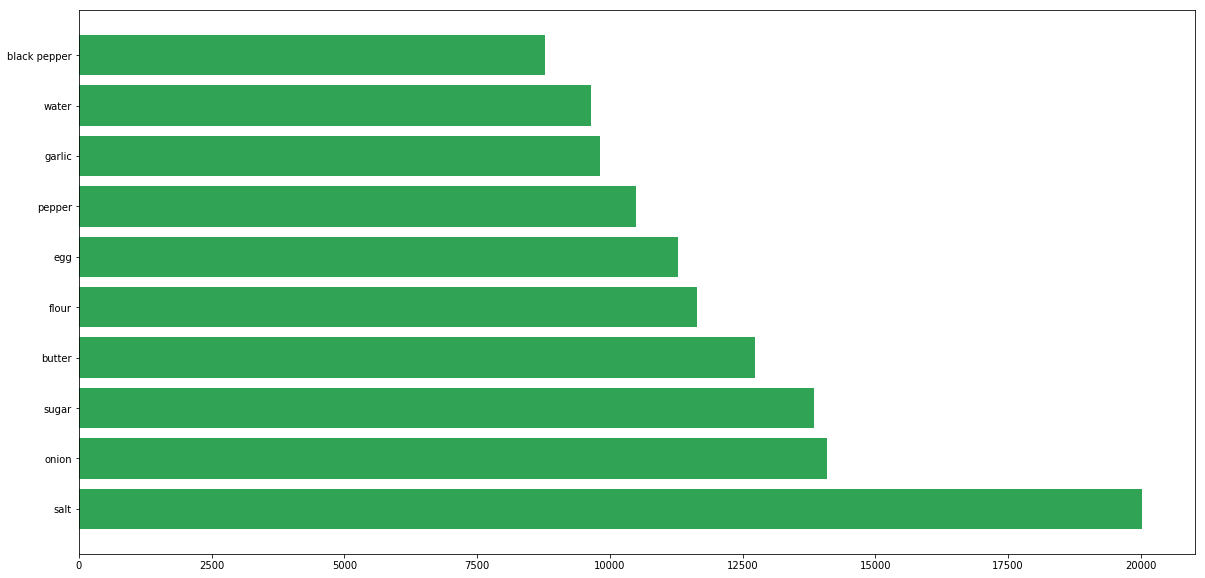

In [15]:
# ----- Sort the ingredients by occurrence ----- #
occu=sorted((value,key) for (key,value) in ingred_used.items())
occu[::-1]

ing_occ = pd.DataFrame(occu[::-1]).head(10)
people = ing_occ[1].values
score = ing_occ[0].values
x_pos = np.arange(len(people))
plt.figure(figsize=((20,10)))
plt.barh(x_pos, score,align='center',color='#31a354')
plt.yticks(x_pos, people) 
plt.show()

## 3/ Co-occurences and Covariance

### Co-occurences


In [17]:
# ----- Using K-NN to find the the association between ingredient ----- #
newdf = ingredients_frame.notnull().astype('int')
coocc = newdf.T.dot(newdf)
display(coocc.head(10))

,acidulated water,acorn squash,agave,ale,aleppo pepper,allspice,almond,almond extract,almond milk,amaranth,...,worcestershire sauce,wrap,yam,yeast,yellow lentil,yoghurt,yogurt,yuzu,zest,zucchini
acidulated water,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acorn squash,0,65,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
agave,0,0,50,0,0,1,6,2,1,1,...,1,0,0,2,0,0,1,0,0,2
ale,0,0,0,17,0,0,2,0,0,0,...,3,0,0,0,0,0,0,0,1,0
aleppo pepper,0,0,0,0,4,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
allspice,0,1,1,0,0,604,17,5,0,0,...,26,0,3,4,0,0,9,0,25,11
almond,0,1,6,2,0,17,1064,93,3,0,...,18,0,0,15,0,0,31,0,47,9
almond extract,0,0,2,0,0,5,93,442,1,0,...,0,0,0,7,0,0,6,0,12,1
almond milk,0,0,1,0,0,0,3,1,32,0,...,0,0,0,3,0,0,1,0,1,0
amaranth,0,0,1,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


#### Similarity and best association of ingredients
Using the co-occurence matrice we compute with the k- Nearest Neighbourg Regression, the proximity between ingredients and end up with a combination of ingredients which would be likely associated to a specific ingredient.

For instance, for apple chutney we find ingredients that is great when they are combined.

In [20]:
r=0.4
number_neighbors_toshow=5
neigh = NearestNeighbors(number_neighbors_toshow,r)
neigh.fit(coocc.values)

b = neigh.kneighbors(coocc.values, return_distance=False)
a = pd.DataFrame(b)
d = dict(zip(range(len(ingredients_frame.columns)),list(ingredients_frame.columns)))
a.replace(d, inplace=True)
a.rename(index=d,inplace=True)
a.loc['apple chutney'][1:]

1        lamb rack
2      ginger beer
3       herbal tea
4    clotted cream
Name: apple chutney, dtype: object

#### Check similiraties between recipes:

In [22]:
r=0.4
number_neighbors_toshow=5
neigh = NearestNeighbors(number_neighbors_toshow,r)
neigh.fit(newdf.values)
b = neigh.kneighbors(coocc.values, return_distance=False)
a = pd.DataFrame(b)
d = dict(zip(range(len(ingredients_frame.columns)),list(ingredients_frame.columns)))
a.replace(d, inplace=True)
a.rename(index=d,inplace=True)

In [27]:
a.head()

,0,1,2,3,4
acidulated water,12002,36168,1056,3800,25633
acorn squash,42491,15715,7900,8088,26822
agave,4861,41318,28072,40234,29561
ale,29247,29289,31739,38000,6783
aleppo pepper,34769,30177,32369,13792,28958


### Covariance

C_ij is the covariance between the i th and j th ingredients.

Covariance is just unscaled correlation.  
If a number at a certain position in the covariance matrix is large, then the variable that corresponds to that row and the variable that corresponds to that column change with one another. When one goes up, the other goes up. When one goes down, the other goes down. 

It will help us to know how to adjust quantity between ingredients.

As we implemented 'u' unit for the ingredient that had no unit, therefore could not be directly converted to gram, we cannot numericaly analyse our dataframe. For the time being for replace u by the average of other apparition of that ingredient. We are currently, working on a method to scrap info about average weight of diverse ingredients. (cf web scrapping) 

In [30]:
ratio_u_ingred={}
test_ingredients_frame=ingredients_frame.copy()
for ingred in list(ingredients_frame):
    mean = ingredients_frame[ingred].apply(pd.to_numeric, errors='coerce').dropna(axis=0, how='any').mean()
    if math.isnan(mean):
        mean=1
    test_ingredients_frame[ingred][ingredients_frame[ingred].astype(str).str.contains('u')]=mean
    #calculate the ratio of unit in each ingredient:
    ratio_u_ingred[ingred]=\
    sum(ingredients_frame[ingred].dropna(axis=0, how='any').astype(str).str.contains('u'))/len(ingredients_frame[ingred].dropna(axis=0, how='any').astype(str).str.contains('u'))

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
ingr_matrix=test_ingredients_frame.fillna(0).values.T
covar=np.cov(ingr_matrix)

## 4/ Linear Regression
With the linear regression on the nutrients information from the data, we will be able to compute an approximation of nutrient value for each ingredient so that we can approximate the nutrient value for the recipes which the value was missing in the dataset

In [32]:
from sklearn.linear_model import LinearRegression
nutri_data=raw_data[['kcal_total','kcal_carb','kcal_fat','kcal_protein','mg_sodium','mg_cholesterol']].copy()
a = nutri_data.replace('?',np.nan)
a.dropna(axis=0,how='any',inplace=True)

ingredients_frame=test_ingredients_frame
ingredients_frame['Total'] = a['kcal_total']
ingredients_frame['Carbohyd'] = a['kcal_fat']
ingredients_frame['fat'] = a['kcal_fat']
ingredients_frame['protein'] = a['kcal_protein']
ingredients_frame['mg_sodium'] = a['mg_sodium']
ingredients_frame['mg_cholestrol'] = a['mg_cholesterol']

display(ingredients_frame.head())
Train_set = ingredients_frame.dropna(subset=['Total'])

,acidulated water,acorn squash,agave,ale,aleppo pepper,allspice,almond,almond extract,almond milk,amaranth,...,yoghurt,yogurt,yuzu,zest,zucchini,Total,Carbohyd,protein,mg_sodium,mg_cholestrol
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,257.1,7.2,21.2,95.4,2.5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,237,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We expect better result once we will have corrected the weight of "unit" ingredients.

In [33]:
from sklearn.metrics import mean_absolute_error

X = Train_set.drop(['Total','Carbohyd','fat','protein','mg_sodium','mg_cholestrol'],axis=1)
X = X.replace(np.nan,0)
Y = Train_set['Total'] 

X_train = X[:20000]
Y_train = Y[:20000]

X_test = X[20000:]
Y_test = Y[20000:]
#we will fit on the entire datas, for now we just try how good is our model 

line_reg = LinearRegression()
line_reg.fit(X_train ,Y_train)
line_reg.coef_[np.where(line_reg.coef_ < 0)] = 0
Y_predict = line_reg.predict(X_test)

print(mean_absolute_error(Y_test,Y_predict))

223.294664151


## 5/ Next step and final goal

- Check for outliers in the data in order to improve our results.
By outliers in the recipes we mean for exemple, quantities of ingredients that are aberrant compared with the quantities of the other ingredients in the recipe.

- Improve and optimize the linear regression by appling a better conversion between volume and grams

- Use the covariance, co-occurence and the result of k-NN regression, to make new special recipe based on the association score of ingredients.

- Try to form some clusters based on the nutrients in order to group ingredients into categories.

- Implement constraints like vegan, gluten-free or low-calorie meals with the result from the linear regression


Our goal will be to create new recipes and suggest special recipes from the work that have been done, we believe that it will be possible. Special recipe will be created with the help of the covariance matrix and the co-occurrence matrix. Futhermore the user will be able to add constrains regarding the nutrients present in the recipe, such as gluten free, vegan etc.




## Current work: 

In [36]:
match_ingred=np.load('match_ingred.npy')
#Analyse the matching between ingredients that we got in webscrapping  and ingredients that have a ratio of more 
#than 0.2 of 'u' unit and will pose a real problem. 
ratio_u=sorted(key for (key,value) in ratio_u_ingred.items() if value>0.2)
ingred_tocheck=ratio_u
remaining_untreated=[x for x in ingred_tocheck if x not in match_ingred]
remaining_untreated

['acidulated water',
 'acorn squash',
 'aleppo pepper',
 'amaretti',
 'anchovy',
 'aubergine',
 'baguette',
 'banana bread',
 'beansprouts',
 'bechamel',
 'bechamel sauce',
 'beef brisket',
 'beef fillet',
 'beef flank',
 'beef rib',
 'beef rump',
 'beef sausage',
 'beetroot',
 'berry',
 'biscotti',
 'biscuit',
 'bitter',
 'black pepper',
 'blood orange',
 'bouquet garni',
 'bratwurst',
 'bread roll',
 'breadstick',
 'brie cheese',
 'brioche',
 'brown bread',
 'bun',
 'butterhead lettuce',
 'butternut squash',
 'capsicum',
 'carrot cake',
 'catfish',
 'caviar',
 'cavolo nero',
 'chicken breast',
 'chicken leg',
 'chicken thigh',
 'chicken wing',
 'chilli',
 'chinese pancake',
 'chip',
 'chipotle',
 'chocolate cake',
 'chocolate mousse',
 'chorizo',
 'chutney',
 'ciabatta',
 'cilantro',
 'citrus',
 'clam',
 'cod',
 'compote',
 'cottage cheese',
 'coulis',
 'courgette',
 'crab',
 'crayfish',
 'cream cheese',
 'cream liqueur',
 'crepe',
 'crisp',
 'crostini',
 'crudites',
 'crumble',
 'cu

In [37]:
len(remaining_untreated)

254

In [38]:
with open('remaining_untreated.txt', 'w') as f:
    for s in remaining_untreated:
        f.write(s + '\n')